In [6]:
from pathlib import Path
import logging
import numpy as np
import pandas as pd


from scipy.signal import convolve2d
from skimage.morphology import white_tophat
from skimage.morphology import square, disk, diamond
from skimage.exposure import equalize_hist, equalize_adapthist


In [69]:
## Copy from logger.py
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(levelname)-8s %(message)s", datefmt="%m/%d/%Y %I:%M:%S%p"
)
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [70]:
## copy from spillover.py
def load_spillmat(infile=None):
    if not infile:
        infile = r'C:\Users\M088378\Documents\SpilloverCompensation\imc-preprocessor-master\imcpp\data\spillover.csv'
    return pd.read_csv(infile, index_col=0)

def align_spillmat(spillmat, input_metals):
    unique_metals = set(spillmat.index.union(spillmat.columns))
    intsct =  sorted(list(set(input_metals) & unique_metals)) # intersection of channels 
    print("MISSING FROM CONFIG: {}".format(','.join(set(input_metals).difference(set(intsct)))))
    sm = spillmat_raw.reindex(index=intsct, columns=intsct, fill_value=0)
    sm.fillna(0,inplace=True)
    filled = sm.values
    np.fill_diagonal(filled, 1.0)
    return pd.DataFrame(filled, index=sm.index, columns=sm.columns)


In [ ]:
## copy from processing.py

def conway(im, selem=disk(1), threshold=None):
    if threshold is None:
        threshold = selem.sum() // 2 + 1

    b = im.astype(bool).astype(int)
    m = convolve2d(b, selem, mode="same")
    im_ = im.copy()
    im_[m < threshold] = 0
    return im_


def tophat(im, selem=square(2)):
    b = im.copy().astype(bool).astype(int)
    m = b - white_tophat(b, selem=selem)
    im_ = im.copy()
    im_[~m.astype(bool)] = 0
    return im_


def compensate(img_stack, spillmat):
    swapped = False
    if img_stack.shape[0] == spillmat.shape[0]:
        img_stack = np.moveaxis(img_stack, 0, 2)
        swapped = True
    comp_ = img_stack @ np.linalg.inv(spillmat.T)
    comp_ = np.round(np.clip(comp_, 0, comp_.max())).astype(np.uint16)
    if swapped:
        comp_ = np.moveaxis(comp_, 2, 0)
    return comp_


def equalize(img_stack, adaptive=False):
    L = img_stack.shape[0]

    logger.debug("5th and 95th percentile before equalization")
    logger.debug(
        np.column_stack(
            (
                np.arange(1, L + 1),
                np.percentile(img_stack, 5, axis=(1, 2)),
                np.percentile(img_stack, 95, axis=(1, 2)),
            )
        )
    )

    if adaptive:
        equalized = np.array(
            [
                equalize_adapthist(img_stack[k, ...], nbins=2 ** 16, clip_limit=0.4)
                for k in range(L)
            ]
        )
    else:
        equalized = np.array(
            [equalize_hist(img_stack[k, ...], nbins=2 ** 16) for k in range(L)]
        )
    return equalized


pixel_removal_functions = {"conway": conway, "tophat": tophat}


In [ ]:
## copy from processing.py
def run_compensation(mcd, options):
    logger.info("Running compensation")
    logger.debug(
        "Note that all channels of the aquisition to be utilized during the "
        "compensation calculation but only those specified in the config "
        "file will be saved."
    )
    if options.spillover_matrix_file:
        logger.info(f"Using provided spillover matrix {options.spillover_matrix_file}")
    spillmat_raw = load_spillmat(options.spillover_matrix_file)

    for ac_options in options.acquisitions:
        report_maxima(mcd, ac_options)
        ac_id = ac_options.acquisition_id
        logger.debug(f". compensating acquisition {ac_id}.")
        spillmat = align_spillmat(spillmat_raw, mcd.channel_metals[ac_id])
        uncomp = mcd.get_data(ac_id)
        comp = compensate(uncomp, spillmat.values)
        mcd.set_data(comp, ac_id)

    if options.compensate_output_type:
        logger.info("Saving compensation results.")
        acquisitions = options.export_acquisitions()
        mcd.save(
            acquisitions,
            options.compensate_output_type,
            prefix=options.output_prefix,
            suffix=options.compensate_output_suffix,
        )

    logger.info("Compensation complete.")


In [102]:
import os,sys,re,glob,math
import tifffile as tf
import xml.etree.ElementTree as ET
## Image by OpenCV
import cv2
# Need to launch Jupyter with IMCtools in Env.
#from apeer_ometiff_library import io, processing, omexmlClass
from skimage import data, img_as_float, io
import matplotlib.pyplot as plt
from types import SimpleNamespace
from pprint import pprint

base=r'R:\PUBLIC\Hyperion_Imaging\Comfere_Nneke_MD\RaymondDevelopments/'
             
d = {
    'spillover_matrix_file' : os.path.join(base,'CopyofMass_Cytometry_Compensation.csv')
}
options = SimpleNamespace(**d)
             
targets = list(filter( os.path.isfile, glob.glob( os.path.join(base,'OMETIFFs','*.ome.tiff') ) ))
print("Loading "+str(len(targets))+" file(s).")


spillmat_raw = load_spillmat(options.spillover_matrix_file)
# spillmat_raw
#

inFile = targets[0]

t = tf.TiffFile(inFile);
print("Number of Channels: {}".format(len(t.pages)))
#pprint(t)
tiffHeader = ET.fromstring(t.pages[0].description)

def formatMetadata(tiffHeader):
    idx = 0
    acquisitions=[]
    for ele in metadata.findall('.//*'):
        chMeta = dict(ele.attrib)
        #print("Index: {}".format(idx))
        if 'Fluor' in chMeta:
            lbl = ele.attrib['Fluor']
            acquisitions.append({
                "Label":ele.attrib['Name'],
                "Metal":lbl.split("(")[0],
                "Ch": lbl.split("(")[1].replace(")",""),
                "Index":idx
            })
            idx+=1
    return acquisitions

myMeta = formatMetadata(tiffHeader)
pprint(myMeta)
channel_metals = [e['Ch']+e['Metal'] for e in myMeta]

#pprint(channel_metals)  
chIdx = 0
imgMk = t.pages[chIdx].asarray()
m = np.max(imgMk)
#   if m > 1e5:
#            logger.warn(f"Channel {acid}/{ch_id}:{label}:{metal} maximum value is {m}")
#        else:
#            logger.debug(f"Channel {ch_id}:{label}:{metal} maximum value: {m}")

print(f"IDX-{chIdx} Channel {myMeta[chIdx]['Ch']}:{myMeta[chIdx]['Label']}:{myMeta[chIdx]['Metal']} maximum value: {m}")
     
spillmat = align_spillmat(spillmat_raw, channel_metals)
print("\n")
spillmat



Loading 55 file(s).
Number of Channels: 32
[{'Ch': '141', 'Index': 0, 'Label': 'SMA', 'Metal': 'Pr'},
 {'Ch': '142', 'Index': 1, 'Label': 'CD19', 'Metal': 'Nd'},
 {'Ch': '143', 'Index': 2, 'Label': 'Vimentin', 'Metal': 'Nd'},
 {'Ch': '144', 'Index': 3, 'Label': 'cd14', 'Metal': 'Nd'},
 {'Ch': '145', 'Index': 4, 'Label': 'CD5', 'Metal': 'Nd'},
 {'Ch': '146', 'Index': 5, 'Label': 'CD16', 'Metal': 'Nd'},
 {'Ch': '148', 'Index': 6, 'Label': 'Pan-Ker', 'Metal': 'Nd'},
 {'Ch': '149', 'Index': 7, 'Label': 'CD11b', 'Metal': 'Sm'},
 {'Ch': '150', 'Index': 8, 'Label': 'PD-L1', 'Metal': 'Sm'},
 {'Ch': '152', 'Index': 9, 'Label': 'CD45', 'Metal': 'Sm'},
 {'Ch': '154', 'Index': 10, 'Label': 'CD11c', 'Metal': 'Sm'},
 {'Ch': '155', 'Index': 11, 'Label': 'FoxP3', 'Metal': 'Gd'},
 {'Ch': '156', 'Index': 12, 'Label': 'CD4', 'Metal': 'Gd'},
 {'Ch': '158', 'Index': 13, 'Label': 'E_Cadherin', 'Metal': 'Gd'},
 {'Ch': '159', 'Index': 14, 'Label': 'CD68', 'Metal': 'Tb'},
 {'Ch': '160', 'Index': 15, 'Label': '

,141Pr,142Nd,143Nd,144Nd,145Nd,146Nd,148Nd,149Sm,150Sm,152Sm,...,168Er,169Tm,170Er,171Yb,173Yb,174Yb,175Lu,176Yb,191Ir,193Ir
141Pr,1.0,0.0051,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
142Nd,0.0,1.0000,0.0062,0.0033,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
143Nd,0.0,0.0081,1.0000,0.0208,0.0021,0.0023,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
144Nd,0.0,0.0023,0.0023,1.0000,0.0092,0.0032,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
145Nd,0.0,0.0030,0.0021,0.0120,1.0000,0.0435,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
146Nd,0.0,0.0033,0.0015,0.0036,0.0025,1.0000,0.0027,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
148Nd,0.0,0.0049,0.0022,0.0050,0.0000,0.0070,1.0000,0.0027,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
149Sm,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0083,1.0000,0.0,0.0033,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
150Sm,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
152Sm,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,1.0000,...,0.0034,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0


In [ ]:

swapped = False
if img_stack.shape[0] == spillmat.shape[0]:
img_stack = np.moveaxis(img_stack, 0, 2)
swapped = True
comp_ = img_stack @ np.linalg.inv(spillmat.T)
comp_ = np.round(np.clip(comp_, 0, comp_.max())).astype(np.uint16)
if swapped:
comp_ = np.moveaxis(comp_, 2, 0)
return comp_





In [72]:
spillmat.shape[0]

32

In [73]:
 np.linalg.inv(spillmat.T)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.10029202e-03,  1.00005726e+00, -8.04035295e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.15852266e-05, -6.19318169e-03,  1.00010478e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.03643980e-09, -7.91458785e-07, -4.91925818e-06, ...,
         1.00000488e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

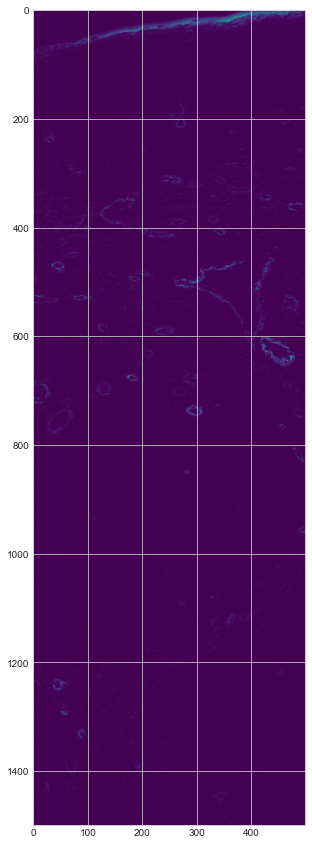

In [92]:
plt.figure(figsize=(10, 15))
plt.imshow(imgMk, cmap='viridis')
plt.show()

In [117]:
x = np.zeros((4, 5,32))
np.moveaxis(x, 2, 0).shape


(32, 4, 5)

In [81]:
   
h,w = np.shape(imgMk)
tiffarray = np.zeros((h,w,32))
for i in range(32):
    tiffarray[:,:,i] = t.pages[i].asarray()
tiffarray  

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.00431015e+02, 1.07648483e+02, 2.89570020e+03, ...,
         1.06307152e+02, 3.24138355e+00, 1.00000000e+00],
        [1.91195297e+02, 1.10809822e+02, 2.81086621e+03, ...,
         9.18513412e+01, 0.00000000e+00, 1.00000000e+00],
        [2.14605118e+02, 1.12669991e+02, 3.10718848e+03, ...,
         1.11503647e+02, 2.34483194e+00, 1.14305437e+00]],

       [[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

C:\Users\M088378\AppData\Local\Temp/ipykernel_9988/4240522120.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


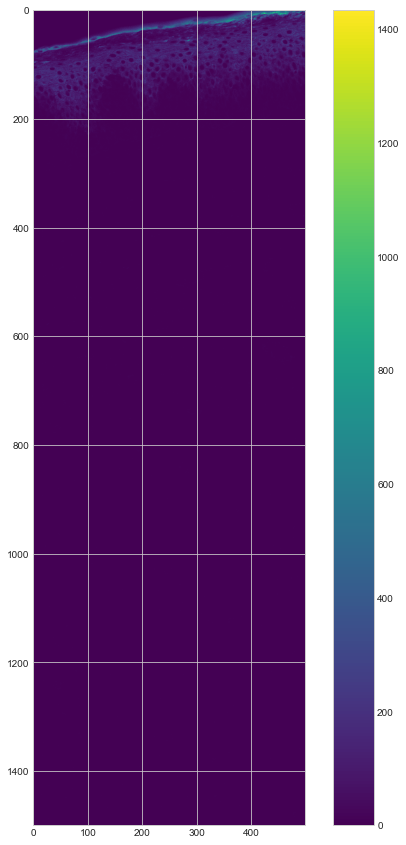

In [110]:

plt.figure(figsize=(10, 15))
plt.imshow(tiffarray[:, :, 6], cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
comp_ = tiffarray @ np.linalg.inv(spillmat.T)
comp_ = np.round(np.clip(comp_, 0, comp_.max())).astype(np.uint16)

C:\Users\M088378\AppData\Local\Temp/ipykernel_9988/3227422012.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


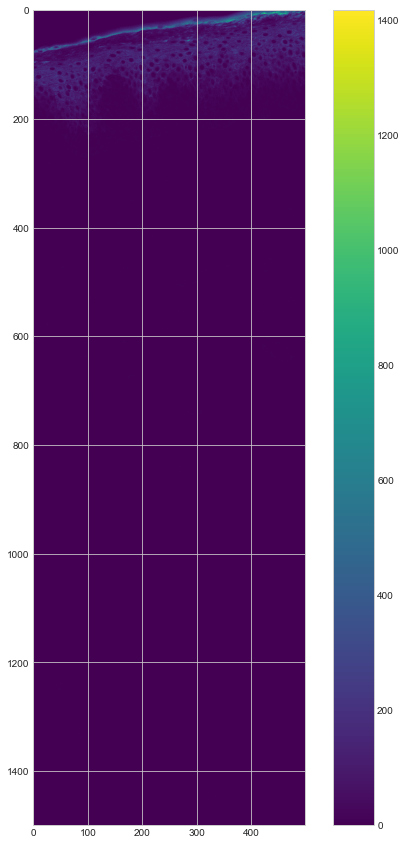

In [125]:
plt.figure(figsize=(10, 15))
plt.imshow(comp_[:,:,6], cmap='viridis')
plt.colorbar()
plt.show()

C:\Users\M088378\AppData\Local\Temp/ipykernel_9988/2095589991.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


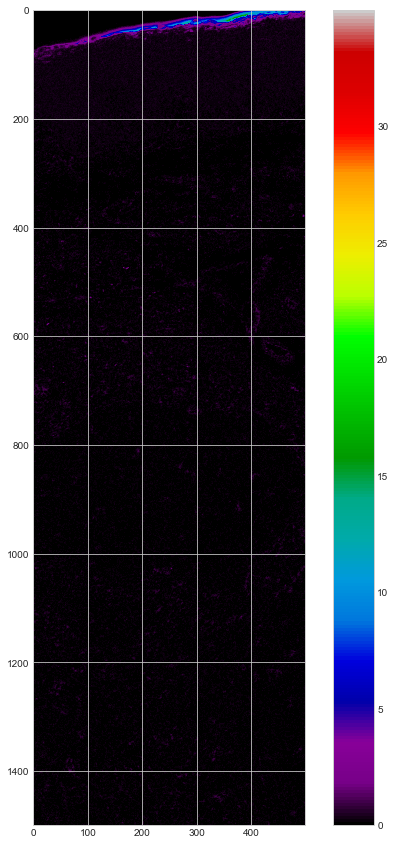

In [122]:
dist = np.abs(tiffarray[:, :, 6] - comp_[:,:,6])
plt.figure(figsize=(10, 15))
plt.imshow(dist, cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [129]:
import xarray as xr

outpath = inFile.replace('OMETIFFs','COMPENSATION')

#comp_ = np.moveaxis(comp_, 2, 0)


xdata = xr.DataArray(comp_,
            dims=("y", "x", "c" ),
            coords={"x": range(comp_.shape[1]), "y": range(comp_.shape[0]), 
                    "c": channel_metals}
        )
xdata = xdata.transpose("c", "y", "x")


tf.imwrite(outpath, data=xdata, description=t.pages[0].description, contiguous=True, resolution=(25400, 25400, "inch"))

comp_.shape

(1500, 500, 32)

In [119]:
tiffarray.shape

(1500, 500, 32)

'<?xml version="1.0" encoding="UTF-8"?>\n    <OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"\n            xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"\n            xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">\n        <Image ID="Image:0" Name="req22976_OKCI_tonsil_ROI_001.ome">\n            <Pixels BigEndian="false"\n                    DimensionOrder="XYZCT"\n                    ID="Pixels:0"\n                    Interleaved="false"\n                    SizeC="32"\n                    SizeT="1"\n                    SizeX="500"\n                    SizeY="1500"\n                    SizeZ="1"\n                    PhysicalSizeX="1.0"\n                    PhysicalSizeY="1.0"\n                    Type="float">\n                <TiffData />\n                <Channel ID="Channel:0:0" Name="SMA" Fluor="Pr(141)" SamplesPerPixel="1"  ContrastMethod="Fluorescence" />\n<Channel ID="Channel